In [2]:
# viewing neural data
%matplotlib inline
import pdb
import sys
import pandas as pd
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib
import scipy.signal as sg
import math
import scipy as sp
import socket
import os
import wave
import struct
import h5py
from scipy.signal import hilbert
from scipy.stats import pearsonr
from scipy.io import wavfile
from scipy.signal import spectrogram
from basic_viewing import h5_functions as h5
import logging

matplotlib.style.use('ggplot')


# Check wihic computer to decide where the things are mounted
comp_name=socket.gethostname()
print 'Computer: ' + comp_name
if  comp_name == 'chim':
    #sys.path.append('/Users/zeke/experiment/ephysDataManagement/ephysScripts')
    experiment_folder = os.path.join(os.path.abspath('W:') , "earneodo", "bci_zf")
elif  'lookfar' in comp_name:
    repos_folder = os.path.abspath('/Users/zeke/reposs')
    experiment_folder = os.path.join(os.path.abspath('/Volumes') , 'gentner', 'earneodo', 'bci_zf')

elif 'lintu' in comp_name:
    repos_folder = os.path.abspath('/mnt/cube/earneodo/repos')
    experiment_folder = os.path.join('/mnt/cube/earneodo/bci_zf/')

elif 'passaro' in comp_name:
    repos_folder = os.path.abspath('/mnt/cube/earneodo/repos')
    experiment_folder = os.path.join('/mnt/cube/earneodo/bci_zf/')

sys.path.append(os.path.join(repos_folder, 'soundflow', 'sound_tools'))
sys.path.append(os.path.join(repos_folder, 'ephysflow'))
sys.path.append(os.path.join(repos_folder, 'analysis-tools'))

import soundtools as st
import Kwik as oe


raw_data_folder = os.path.join(experiment_folder, 'raw_data')
ss_data_folder = os.path.join(experiment_folder, 'ss_data')


#given a chunk that contains a sine wave, find its onset
def peaks(signal, min_height=0):
    np.where(signal[1:-1]>min_height)
    peak_ind = [i for i in np.where(signal[1:-1]>min_height)[0] if signal[i]>signal[i-1] & signal[i]>signal[i+1]]
    return peak_ind

def find_onset_sine(chunk, freq=1000, f_s=30000):
    roof = int(max(chunk)*0.25)
    first_peak = peaks(chunk, min_height=roof)[0]
    
    onset = first_peak - int(f_s/(4.*freq))
    return onset

def envelope(x, window=200):
    analytic_signal = hilbert(x)
    amplitude_envelope = np.abs(analytic_signal)
    w=np.ones(window, 'd')
    return np.convolve(w/w.sum(),amplitude_envelope,mode='valid')

def correlation_with_pattern(data, pattern, window, filter_func, *args, **kwargs):
    segment = envelope(filter_func(data, *args, **kwargs), window=window)
    return pearsonr(segment, pattern)[0]

def apply_repeated(s, starts, window, scalar_func, *args, **kwargs):
    # starts, window in sample units
    y = np.empty_like(starts)
    for i_s, start in enumerate(starts):
        a_chunk = st.Chunk(s, segment=[start, start + window])
        y[i_s] = scalar_func(a_chunk.data, *args, **kwargs)

    return y

def band_pass_filter(x, hp_b, hp_a, lp_b, lp_a):    
    x_hi = sg.filtfilt(hp_b, hp_a, x, axis=0)
    x_filt = sg.filtfilt(lp_b, lp_a, x_hi, axis=0)
    return x_filt

def compare_spectrogram(sxx, pattern_sxx):
    return np.sum(np.abs(pattern_sxx-sxx)/np.sum(np.abs(sxx)))

def spectral_score(chunk, pattern_sxx):
    f, t, Sxx = spectrogram(chunk.data, chunk.sound.s_f, nperseg = n_window, noverlap=n_overlap, 
                        window = sg.gaussian(n_window, sigma), scaling='spectrum')
    assert(Sxx.shape == pattern_sxx.shape)
    return compare_spectrogram(Sxx, pattern_sxx)



Computer: passaro


In [234]:
#file structure
bird_id = 'z020'
sess = 'day-2016-06-02'
rec = 2
run = 1
processor = ''

raw_file_folder = os.path.join(ss_data_folder, bird_id, sess)
raw_file_base_name = 'experiment'

raw_file_name = raw_file_base_name + processor + '.raw.kwd'
evt_file_name = raw_file_base_name + '.evt.kwd'

raw_file_path = os.path.join(raw_file_folder, raw_file_name)
evt_file_path = os.path.join(raw_file_folder, evt_file_name)

# open the file in read mode
raw_file = h5py.File(raw_file_path, 'r')
#evt_file = h5py.File(evt_file_path, 'a')

# load it with the open-ephys api for version 2 of kiwk format

oe_file = oe.load(raw_file_path)


In [235]:
# list records
raw_file['recordings'].keys()

[u'0', u'1', u'2', u'3', u'4', u'5']

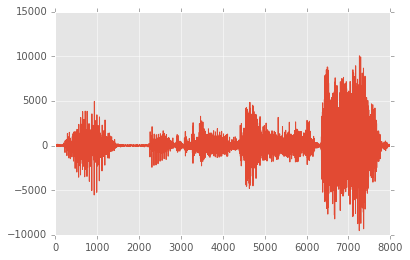

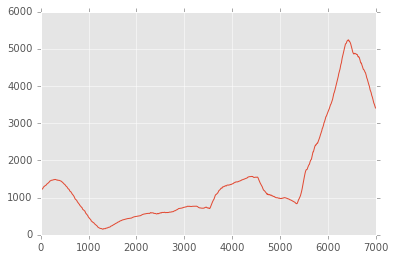

In [237]:
# get the sound and the pattern
chan_name = "CH17"
chan_number = 16
data_table = raw_file['/recordings'][str(rec)]['data']
chan_sf = oe.get_sample_rate(raw_file)
pattern = 1
#filter parameters
filt_lo = 10000 #Hz
filt_hi = 500 #Hz

# sonogram parameters
n_window = 256;
n_overlap = 192;
f_cut = 10000;
sigma = 1./1000.*chan_sf

#template match parameters
window_env = 1000

audio_slice = h5.load_table_slice(data_table, np.arange(0, data_table.shape[0]), [chan_number])
#chan_sound = st.DatSound(audio_slice[int(3674.214226*30000.) - 16000:int(3674.214226*30000.)+160000,0], chan_sf, data_type=np.float)
chan_sound = st.DatSound(audio_slice[:,0], chan_sf, data_type=np.float)
# # Now try to save a channel as a wav file
# from scipy.io import wavfile
# out_file_name = raw_file_base_name +  '_' + chan_name + 'song.wav'
# wavfile.write(os.path.join(raw_file_folder, out_file_name),chan_sf, np.array(chan_sound.stream, dtype='int16'))

#make the filter for the data file
s_f = chan_sound.s_f
#The band where we expect most of the energy of zf song to be in
hp_b, hp_a = sg.butter(4, filt_hi/(s_f/2.), btype='high')
lp_b, lp_a = sg.butter(4, filt_lo/(s_f/2.), btype='low')

# read a bout from a wave file and prepare the templates 
pattern_name = 'motiff_' + str(pattern) + '.wav'
pattern_path = os.path.join(raw_file_folder, pattern_name)

pattern_sound = st.WavData2(pattern_path)
pattern_chunk = st.Chunk(pattern_sound)
pattern_chunk.apply_filter(st.bandpass_filter, s_f)
plt.plot((pattern_chunk.data))
pattern_envelope = st.envelope(pattern_chunk.data[:,0], window=window_env)
plt.figure()
plt.plot(pattern_envelope)
pattern_spectrogram = spectrogram(pattern_chunk.data[:,0], s_f, nperseg = n_window, noverlap=n_overlap, 
                        window = sg.gaussian(n_window, sigma), scaling='spectrum')
plt.figure()


In [6]:
# try to get the template matches from soundtools functions
import threading
from IPython.display import display

class chunkFunction():
    def __init__(self, chunk, function, *args, **kwargs):
        print args
        self.chunk = chunk
        self.func = function
        self.args = args
        self.kwargs = kwargs

    def start(self):
        display('Starting function {0}'.format(self.func.func_name))
        for arg in self.args:
            print arg
        for key, arg in self.kwargs.iteritems():
            print key
            print arg
        self.chunk.apply_filter(self.func, *self.args, **self.kwargs)
        print "done"

class threadFunction():
    def __init__(self, function, *args, **kwargs):
        self.func = function
        self.args = args
        self.kwargs = kwargs
        self.out = None

    def run(self):
        display('Starting function {0}'.format(self.func.func_name))
        for arg in self.args:
            print arg
        for key, arg in self.kwargs.iteritems():
            print key
            print arg
        self.out = self.func(*self.args, **self.kwargs)
        print "done"

In [7]:
# create logger with 'spam_application'
logger = logging.getLogger('searching_motiff')
logger.setLevel(logging.DEBUG)
# create file handler which logs even debug messages
fh = logging.FileHandler('search_motiff.log')
fh.setLevel(logging.DEBUG)
# create console handler with a higher log level
ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
# create formatter and add it to the handlers
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fh.setFormatter(formatter)
ch.setFormatter(formatter)
# add the handlers to the logger
logger.addHandler(fh)
logger.addHandler(ch)

logger.info('Begin to search')

st.find_peaks(np.array([0, 1, 0]))

2016-06-25 00:49:04,057 - searching_motiff - INFO - Begin to search


array([0])

In [238]:
def find_happy_song(chan_sound, pattern_chunk):
    window_env = 500
    logger.info('Begin to search')
    envelope_matches = st.match_by_envelope(chan_sound, pattern_chunk, window_size=window_env)
    candidates = pd.DataFrame({'start' : envelope_matches['peaks'],
                           'env_corr': envelope_matches['corr'][envelope_matches['peaks']],
                           'spectral_diff': np.zeros_like(envelope_matches['peaks'], dtype=np.float)})
    
    logger.info('Found {0} candidates'.format(candidates.size))
    
    if candidates.size>0:
        logger.info('Getting spectrogram scores')
        st.spectrogram_scores(pattern_chunk, chan_sound, candidates)
        if candidates.size>1:
            logger.info('Clustering candidates')
            st.cluster_spectrograms(candidates)
    else:
        pass

    return candidates

task_find_happy_song = threadFunction(find_happy_song, chan_sound, pattern_chunk)

threads = []
t = threading.Thread(name= 'task_find_happy_song', 
                     target=task_find_happy_song.run)
threads.append(t)
t.start()

'Starting function find_happy_song'

<soundtools.DatSound instance at 0x7feae6d51fc8>
<soundtools.Chunk instance at 0x7feae778efc8>


2016-07-06 00:49:19,200 - searching_motiff - INFO - Begin to search


In [247]:
t.isAlive()

True

In [263]:
spectrogram_kwargs = {'nperseg': n_window,
                    'noverlap': n_overlap,
                    'window': sg.gaussian(n_window, sigma),
                    'scaling': 'spectrum'}

result = task_find_happy_song.out
all_candidates = result[result['bout']==True].sort_values('spectral_diff').reset_index()
rms_thresh = 10000.638761;

for (i, start) in enumerate(all_candidates['start']):
    motif_start = start - pattern_chunk.samples
    #print all_candidates[i]
    series = chan_sound.get_chunk(motif_start, motif_start + pattern_chunk.samples)
    # get the histogram
    #f, t, sxx = spectrogram(st.bandpass_filter(series[:, 0], s_f), s_f, **spectrogram_kwargs)
    # get the rms
    #print rms(st.bandpass_filter(series[:, 0], s_f))
    all_candidates.set_value(i, 'rms', rms(st.bandpass_filter(series[:, 0], s_f)))
    #plt.figure()
    #plt.pcolormesh(t, f[f < f_cut], np.log(sxx[f < f_cut, :]))

all_candidates = all_candidates[all_candidates['rms'] > rms_thresh].reset_index()

In [264]:
all_candidates

,level_0,index,env_corr,spectral_diff,start,bout,rms
0,0,1570,0.856293,0.372561,2497614,True,36786.393681
1,1,122,0.923623,0.400003,16826553,True,23391.633651
2,2,3,0.961325,0.402735,16914527,True,21894.360056
3,3,754,0.883713,0.409777,44257653,True,19162.145204
4,4,1,0.969071,0.411699,16810655,True,22847.262495
5,5,0,0.976161,0.418802,16842008,True,22376.236064
6,6,2,0.966198,0.430990,16853159,True,21608.119810
7,7,447,0.899913,0.434798,44272835,True,17774.708925
8,8,580,0.891451,0.436702,68007245,True,34908.067788
9,9,353,0.905481,0.444339,44299282,True,14927.121521


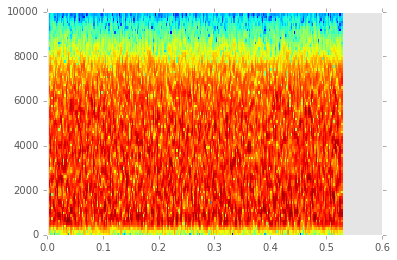

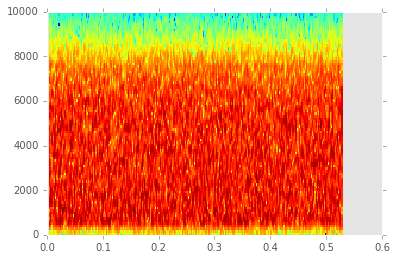

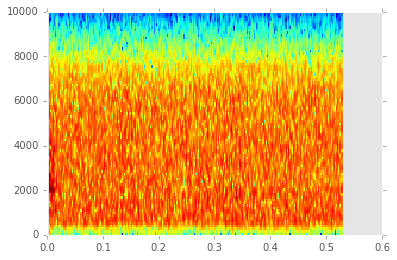

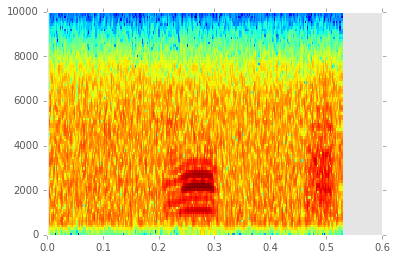

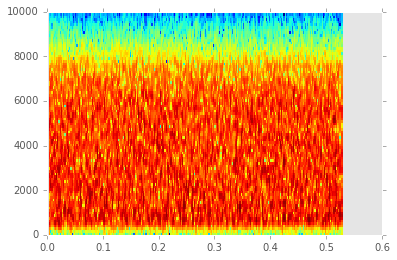

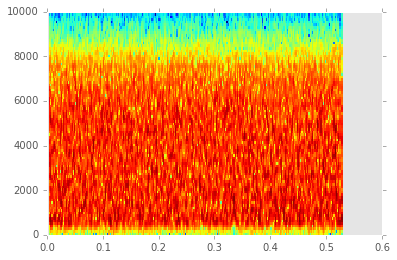

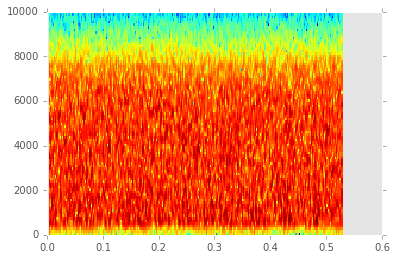

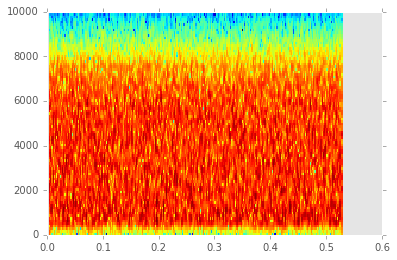

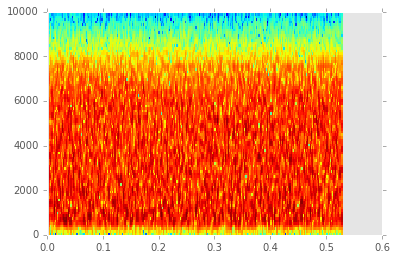

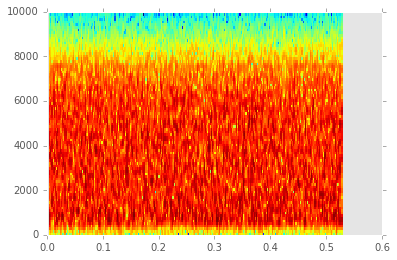

In [257]:
for (i, start) in enumerate(all_candidates['start'][:10]):
    motif_start = start - pattern_chunk.samples
    #print all_candidates[i]
    series = chan_sound.get_chunk(motif_start, motif_start + 2*pattern_chunk.samples)
    # get the histogram
    f, t, sxx = spectrogram(st.bandpass_filter(series[:, 0], s_f), s_f, **spectrogram_kwargs)
    # get the rms
    plt.figure()
    plt.pcolormesh(t, f[f < f_cut], np.log(sxx[f < f_cut, :]))

In [88]:
selected_bouts = all_candidates[all_candidates['level_0']<20]

In [91]:
store_bouts = all_candidates[all_candidates['level_0']<20].sort_values('start')
store_bouts

,level_0,index,env_corr,spectral_diff,start,bout,rms
0,0,0,0.995796,0.157385,110234451,True,149139.272970
8,8,18,0.949269,0.218127,110249735,True,165283.581075
9,9,16,0.950732,0.221661,110261033,True,164965.477235
18,18,960,0.906342,0.255913,110276271,True,197848.284447
5,5,1484,0.894323,0.213220,110291778,True,145877.202995
3,3,10,0.962072,0.210614,110303173,True,169677.047332
7,7,1311,0.898105,0.215117,110317387,True,154659.837123
11,11,14,0.951827,0.223992,110337933,True,166102.004247
10,10,17,0.949304,0.223527,110353480,True,172311.124933
1,1,1,0.987570,0.198346,163220705,True,162737.761205


In [218]:
-

In [211]:
evt_file = h5py.File(evt_file_path, 'a')

evt_file.filename

u'/mnt/cube/earneodo/bci_zf/ss_data/z020/day-2016-06-02/experiment.evt.kwd'

In [202]:
# Save in the file
def append_rows(table, new_data):
    rows = table.shape[0]
    more_rows = new_data.shape[0]
    table.resize(rows + more_rows, axis=0)
    if table.size == (rows + more_rows):
        table[rows:] = new_data
    else:
        table[rows:,:] = new_data

def unlimited_rows_data(group, table_name, data):
    try:
        table = group.create_dataset(table_name, data=data, dtype=data.dtype, maxshape={None, None})
    except RuntimeError as e:
        if 'Name already exists' in str(e):
            table = group[table_name]
            append_rows(table, data)
        else:
            raise
    return table

def store_motiff(ev_file, rec, bout_starts, motiff_name):
    motiff_group = ev_file.require_group('/event_types/singing/{0}'.format(motiff_name))
    t_table = unlimited_rows_data(motiff_group, 'time_samples', bout_starts)
    r_table = unlimited_rows_data(motiff_group, 'recording', data=np.ones_like(bout_starts)*int(rec))
    

mot_file_name = raw_file_base_name + '.sng.kwe'
mot_file_path = os.path.join(raw_file_folder, mot_file_name)    

mot_file = h5py.File(mot_file_path, 'a')
store_motiff(mot_file, rec, store_starts, 'motiff_1')
mot_file.close()